In [ ]:
!pip install xgboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_score

from xgboost import XGBClassifier

In [ ]:
df = pd.read_csv("cs-training.csv")
df = df.drop("Unnamed: 0", axis=1)
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [ ]:
df['MonthlyIncome'].fillna(df['MonthlyIncome'].median(), inplace=True)
df['NumberOfDependents'].fillna(df['NumberOfDependents'].median(), inplace=True)

/tmp/ipython-input-203/3341837283.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['MonthlyIncome'].fillna(df['MonthlyIncome'].median(), inplace=True)
/tmp/ipython-input-203/3341837283.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method

In [ ]:
df["DebtIncomeRatio"] = df["DebtRatio"] * df["MonthlyIncome"]

In [ ]:
df["TotalLatePayments"] = (
    df["NumberOfTimes90DaysLate"] +
    df["NumberOfTime60-89DaysPastDueNotWorse"] +
    df["NumberOfTime30-59DaysPastDueNotWorse"]
)

In [ ]:
df["IncomePerDependent"] = df["MonthlyIncome"] / (df["NumberOfDependents"] + 1)

In [ ]:
df["HighUtilization"] = (df["RevolvingUtilizationOfUnsecuredLines"] > 0.8).astype(int)

In [ ]:
df["AgeRisk"] = ((df["age"] < 25) | (df["age"] > 65)).astype(int)

In [ ]:
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,DebtIncomeRatio,TotalLatePayments,IncomePerDependent,HighUtilization,AgeRisk
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,7323.197016,2,3040.0,0,0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,316.878123,0,1300.0,1,0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,258.914887,2,3042.0,0,0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0,118.963951,0,3300.0,0,0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0,1584.975094,1,63588.0,1,0


In [ ]:
X = df.drop("SeriousDlqin2yrs", axis=1)
y = df["SeriousDlqin2yrs"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
y.value_counts()

,count
SeriousDlqin2yrs,
0,139974
1,10026


In [ ]:
scale_pos_weight = y.value_counts()[0] / y.value_counts()[1]
scale_pos_weight

np.float64(13.961101137043686)

In [ ]:
model = XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.03,
    subsample=0.9,
    colsample_bytree=0.9,
    scale_pos_weight=scale_pos_weight*1.2,
    random_state=42,
    eval_metric='logloss'
)

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.80      0.88     27995
           1       0.21      0.77      0.33      2005

    accuracy                           0.79     30000
   macro avg       0.60      0.78      0.61     30000
weighted avg       0.93      0.79      0.84     30000



In [ ]:
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

ROC-AUC: 0.8638739995875643


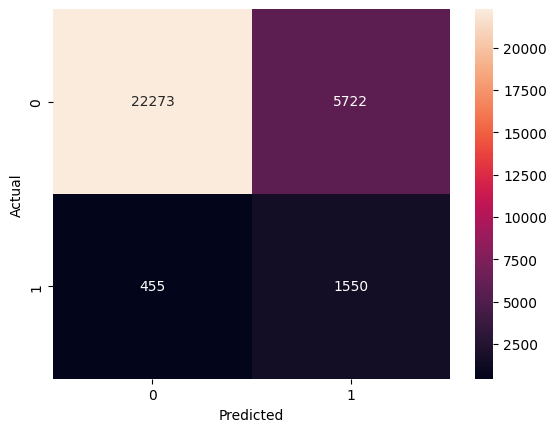

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
threshold = 0.9
y_pred_new = (y_prob > threshold).astype(int)

print(classification_report(y_test, y_pred_new))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97     27995
           1       0.53      0.30      0.38      2005

    accuracy                           0.94     30000
   macro avg       0.74      0.64      0.67     30000
weighted avg       0.92      0.94      0.93     30000



In [ ]:
print("Precision for defaulters at different thresholds:\n")

for t in np.arange(0.5,0.95,0.05):
    y_pred_temp = (y_prob > t).astype(int)
    precision = precision_score(y_test, y_pred_temp)
    print(f"Threshold {t:.2f} → Precision: {precision:.3f}")

Precision for defaulters at different thresholds:

Threshold 0.50 → Precision: 0.213
Threshold 0.55 → Precision: 0.236
Threshold 0.60 → Precision: 0.261
Threshold 0.65 → Precision: 0.295
Threshold 0.70 → Precision: 0.329
Threshold 0.75 → Precision: 0.363
Threshold 0.80 → Precision: 0.406
Threshold 0.85 → Precision: 0.451
Threshold 0.90 → Precision: 0.525


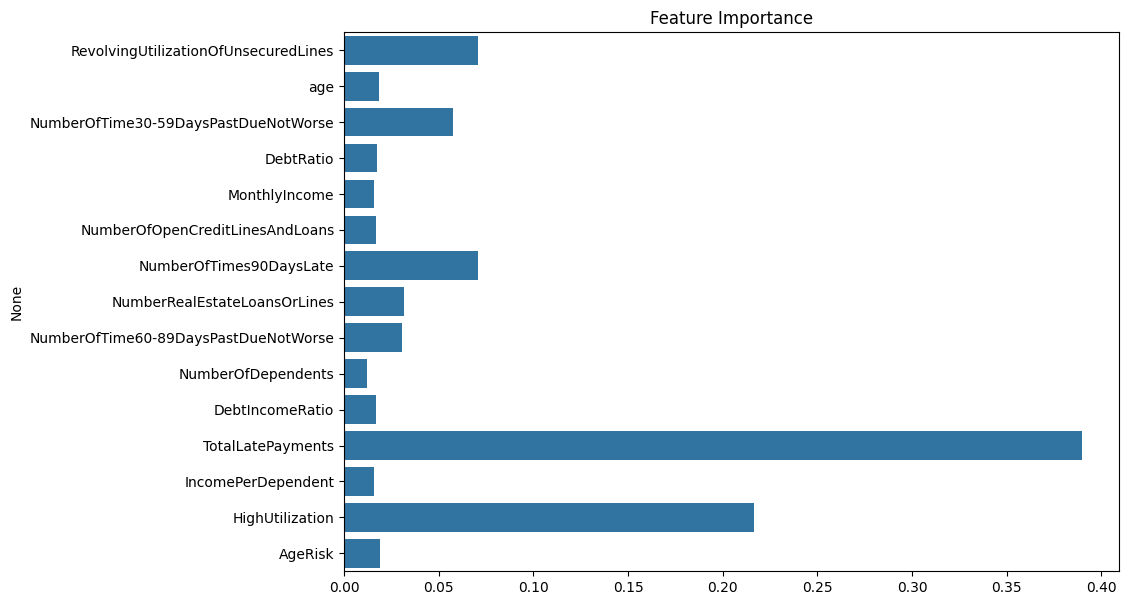

In [ ]:
plt.figure(figsize=(10,7))
sns.barplot(x=model.feature_importances_, y=X.columns)
plt.title("Feature Importance")
plt.show()

In [ ]:
!pip install joblib

In [ ]:
import joblib

joblib.dump(model, "default_model_xgb.pkl")

['default_model_xgb.pkl']

In [ ]:
joblib.dump(X.columns.tolist(), "model_features.pkl")

['model_features.pkl']

In [ ]:
joblib.dump(0.9, "decision_threshold.pkl")

['decision_threshold.pkl']